In [1]:
import sys, os
sys.path.insert(0, os.path.join(os.path.abspath(''), '..'))
from sscode.vortex import preprocess_track, vortex_model

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
allstorms = xr.open_dataset('Allstorms.ibtracs_wmo.v03r10.nc')

In [35]:
np.where((allstorms.name==b'OFA')==True)

(array([3946, 4870]),)

In [38]:
storm = allstorms.isel(storm=4870).dropna(dim='time').drop_dims('center').to_dataframe()
storm = storm.where(storm.pres_wmo>1).dropna()

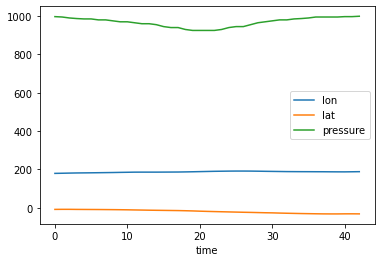

In [39]:
storm.lon_wmo.plot()
storm.lat_wmo.plot()
storm.pres_wmo.plot()
plt.legend(['lon','lat','pressure'])

In [42]:
era5_track_vars={
    'longitude':'lon','latitude':'lat',
    'pressure':'mslp','time':'etc_datetime',
    'maxwinds':'vel850'
}
ibitracs_vars={
    'longitude': 'lon_wmo',
    'latitude': 'lat_wmo',
    'time': 'time_wmo',
    'pressure': 'pres_wmo',
    'maxwinds': 'wind_wmo',
}
x0, y0 = storm.lon_wmo.mean(), storm.lat_wmo.mean()
track_data_processed, times = preprocess_track(
    storm, x0, y0, # center coordinates
    track_vars=ibitracs_vars,
    region_limits=[100,300,80,-80],
    time_resolution='1H',
    interpolation=True,
    interpolation_step='30MIN',
    interpolation_mode='mean',
    great_circle=True, 
    winds_fit=True
)
output_fields = vortex_model(
    track_data_processed, coords_mode='SPHERICAL',
    cg_lon_attrs=[x0-20,x0+20,300],
    cg_lat_attrs=[y0-20,y0+20,300]
)

In [43]:
track_data_processed, output_fields

(                           move        vf       vfx       vfy    pn     p0  \
 1990-01-30 00:00:00  246.540650  0.311814  0.286041  0.124133  1013  996.0   
 1990-01-30 00:30:00  246.540650  0.311814  0.286041  0.124133  1013  996.0   
 1990-01-30 12:00:00  269.944330  0.327150  0.327150  0.000318  1013  992.5   
 1990-01-30 12:30:00  269.944330  0.327150  0.327150  0.000318  1013  992.5   
 1990-01-31 00:00:00  299.948980  0.330371  0.286256 -0.164930  1013  988.5   
 ...                         ...       ...       ...       ...   ...    ...   
 1990-02-09 18:30:00  168.017511  0.675510 -0.140245  0.660792  1013  996.0   
 1990-02-10 00:00:00  256.675440  0.723683  0.704202  0.166785  1013  997.0   
 1990-02-10 00:30:00  256.675440  0.723683  0.704202  0.166785  1013  997.0   
 1990-02-10 06:00:00  305.017275  0.860775  0.704957 -0.493933  1013  998.0   
 1990-02-10 06:30:00  305.017275  0.860775  0.704957 -0.493933  1013  998.0   
 
                             lon        lat  vmax 

<AxesSubplot:xlabel='lon', ylabel='lat'>

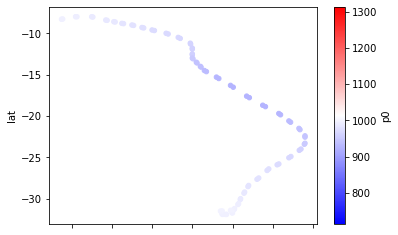

In [44]:
track_data_processed.plot.scatter(
    x='lon',y='lat',c='p0',cmap='bwr',vmin=1013-300,vmax=1013+300
)

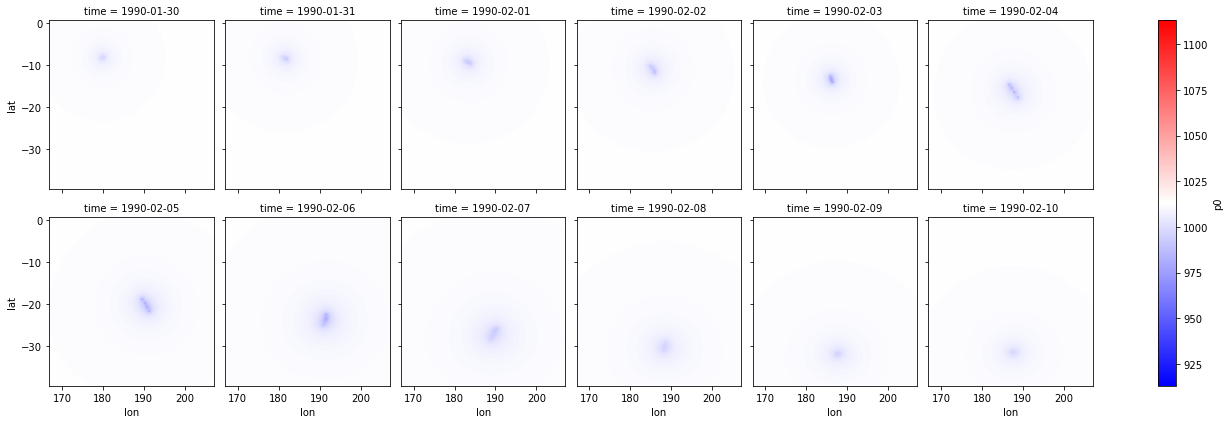

In [67]:
output_fields.p0.resample(time='1D').mean().plot(
    col='time',col_wrap=6,cmap='bwr',vmin=1013-100,vmax=1013+100
)

In [48]:
slp_total = xr.open_dataset('../../SamoaTonga/resources/slp/hindcast/SLP_complete.nc')

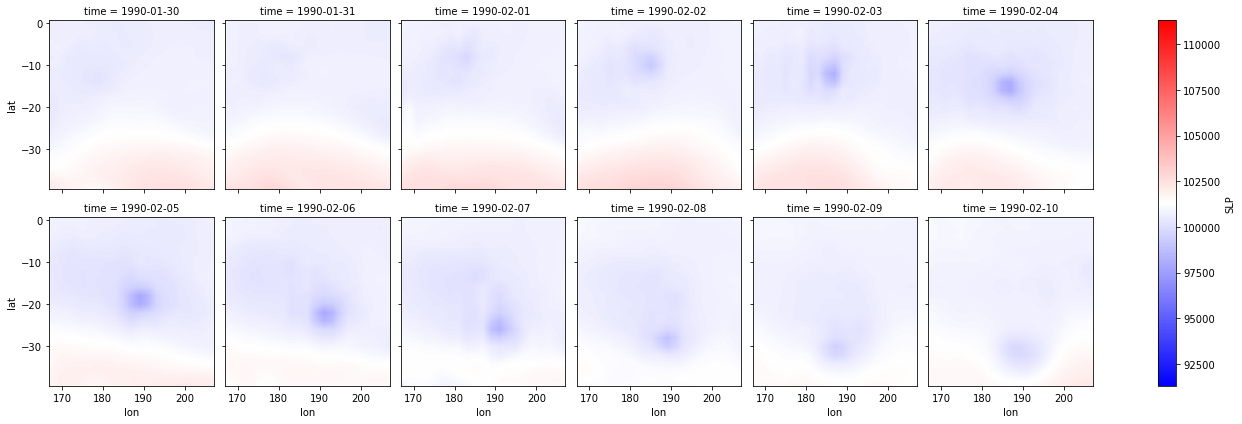

In [66]:
slp_total.SLP.sel(
    time=pd.to_datetime(output_fields.time.values).round('D').unique().values
).interp(longitude=output_fields.lon,latitude=output_fields.lat).plot(
    col='time',col_wrap=6,cmap='bwr',vmin=101300-10000,vmax=101300+10000
)